**심층 신경망 훈련하기**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, f"{fig_id}.{fig_extension}")
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 그레이디언트 소실과 폭주 문제

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

In [3]:
import numpy as np

z = np.linspace(-5, 5, 200)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, 1.2], "k-")
plt.plot([-5, 5], [-3 / 4, 7 / 4], "g--")
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor="black", shrink=0.1)
plt.annotate("Saturating", xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate("Saturating", xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate("Linear", xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
save_fig("sigmoid_saturation_plot")
plt.show()

그림 저장: sigmoid_saturation_plot


## Xavier 초기화와 He 초기화

In [4]:
from tensorflow import keras

[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## 수렴하지 않는 활성화 함수

### LeakyReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

그림 저장: leaky_relu_plot


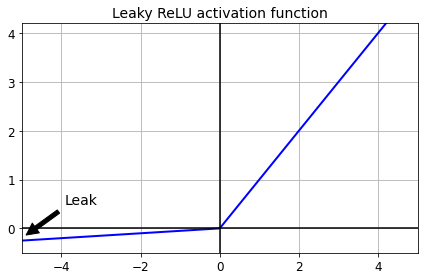

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-0.5, 4.2], "k-")
plt.grid(True)
props = dict(facecolor="black", shrink=0.1)
plt.annotate("Leak", xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
save_fig("leaky_relu_plot")
plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련해 본다:

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal"),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [13]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [14]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 1.2431 - accuracy: 0.6107 - val_loss: 0.8603 - val_accuracy: 0.7178
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7844 - accuracy: 0.7364 - val_loss: 0.7056 - val_accuracy: 0.7612
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6782 - accuracy: 0.7731 - val_loss: 0.6344 - val_accuracy: 0.7880
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6197 - accuracy: 0.7926 - val_loss: 0.5898 - val_accuracy: 0.8010
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5806 - accuracy: 0.8056 - val_loss: 0.5559 - val_accuracy: 0.8168
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5530 - accuracy: 0.8140 - val_loss: 0.5375 - val_accuracy: 0.8214
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5318 - accuracy: 0.8206 - val_loss: 0.5171 - val_accuracy:

PReLU를 테스트해 본다:

In [15]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(100, kernel_initializer="he_normal"),
        keras.layers.PReLU(),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [17]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.3332 - accuracy: 0.5829 - val_loss: 0.8992 - val_accuracy: 0.7130
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.8062 - accuracy: 0.7340 - val_loss: 0.7176 - val_accuracy: 0.7658
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.6846 - accuracy: 0.7755 - val_loss: 0.6337 - val_accuracy: 0.8002
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6207 - accuracy: 0.7966 - val_loss: 0.5847 - val_accuracy: 0.8156
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5793 - accuracy: 0.8095 - val_loss: 0.5503 - val_accuracy: 0.8260
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5499 - accuracy: 0.8173 - val_loss: 0.5298 - val_accuracy: 0.8298
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5286 - accuracy: 0.8229 - val_loss: 0.5096 - val_accuracy:

### ELU

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

그림 저장: elu_plot


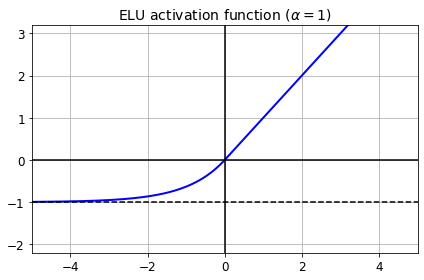

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-1, -1], "k--")
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
save_fig("elu_plot")
plt.show()

텐서플로에서 쉽게 ELU를 적용할 수 있다. 층을 만들 때 활성화 함수로 지정하면 된다:

In [20]:
keras.layers.Dense(10, activation="elu")

### SELU

Günter Klambauer, Thomas Unterthiner, Andreas Mayr는 2017년 한 [훌륭한 논문](https://arxiv.org/pdf/1706.02515.pdf)에서 SELU 활성화 함수를 소개했다. 훈련하는 동안 완전 연결 층만 쌓아서 신경망을 만들고 SELU 활성화 함수와 LeCun 초기화를 사용한다면 자기 정규화된다. 각 층의 출력이 평균과
표준편차를 보존하는 경향이 있다. 이는 그레이디언트 소실과 폭주 문제를 막아 준다. 그 결과로 SELU 활성화 함수는 이런 종류의 네트워크(특히 아주 깊은 네트워크)에서 다른 활성화 함수보다 뛰어난 성능을 종종 낸다. 따라서 꼭 시도해 봐야 한다. 하지만 SELU 활성화 함수의 자기 정규화 특징은 쉽게 깨진다. ℓ<sub>1</sub>나 ℓ<sub>2</sub> 정규화, 드롭아웃, 맥스 노름, 스킵 연결이나 시퀀셜하지 않은 다른 토폴로지를 사용할 수 없다(즉 순환 신경망은 자기 정규화되지 않는다). 하지만 실전에서 시퀀셜 CNN과 잘 동작한다. 자기 정규화가 깨지면 SELU가 다른 활성화 함수보다 더 나은 성능을 내지 않을 것이다.

In [21]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화한다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (
        2 * erfc(np.sqrt(2)) * np.e ** 2 + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e - 2 * (2 + np.pi) * erfc(
    1 / np.sqrt(2)) * np.sqrt(np.e) + np.pi + 2) ** (-1 / 2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-1.758, -1.758], "k--")
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
save_fig("selu_plot")
plt.show()

그림 저장: selu_plot


기본적으로 SELU 하이퍼파라미터(`scale`과 `alpha`)는 각 뉴런의 평균 출력이 0에 가깝고 표준 편차는 1에 가깝도록 조정된다(입력은 평균이 0이고 표준 편차 1로 표준화되었다고 가정한다). 이 활성화 함수를 사용하면 1,000개의 층이 있는 심층 신경망도 모든 층에 걸쳐 거의 평균이 0이고 표준 편차를 1로 유지한다. 이를 통해 그레이디언트 폭주와 소실 문제를 피할 수 있다:

In [24]:
Z = np.random.normal(size=(500, 100))  # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100))  # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print(f"Layer {layer}: mean {means:.2f}, std deviation {stds:.2f}")

Layer 0: mean 0.01, std deviation 1.00
Layer 100: mean 0.00, std deviation 0.98
Layer 200: mean -0.04, std deviation 0.94
Layer 300: mean -0.03, std deviation 0.91
Layer 400: mean -0.01, std deviation 0.89
Layer 500: mean 0.03, std deviation 0.98
Layer 600: mean -0.01, std deviation 0.88
Layer 700: mean -0.03, std deviation 0.93
Layer 800: mean -0.04, std deviation 0.91
Layer 900: mean -0.01, std deviation 0.93


쉽게 SELU를 사용할 수 있다:

In [25]:
keras.layers.Dense(10, activation="selu", kernel_initializer="lecun_normal")

100개의 은닉층과 SELU 활성화 함수를 사용한 패션 MNIST를 위한 신경망을 만들어 본다:

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [27]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

이제 훈련해 본다. 입력을 평균 0과 표준 편차 1로 바꾸어야 한다는 것을 잊지 않는다:

In [28]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [29]:
history = model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 52s 29ms/step - loss: 1.1849 - accuracy: 0.5508 - val_loss: 0.7905 - val_accuracy: 0.7232
Epoch 2/5
1719/1719 [==============================] - 48s 28ms/step - loss: 0.7206 - accuracy: 0.7403 - val_loss: 0.6452 - val_accuracy: 0.7740
Epoch 3/5
1719/1719 [==============================] - 50s 29ms/step - loss: 0.7699 - accuracy: 0.7210 - val_loss: 0.7219 - val_accuracy: 0.7386
Epoch 4/5
1719/1719 [==============================] - 48s 28ms/step - loss: 0.7735 - accuracy: 0.7178 - val_loss: 0.7590 - val_accuracy: 0.7206
Epoch 5/5
1719/1719 [==============================] - 49s 29ms/step - loss: 0.7329 - accuracy: 0.7306 - val_loss: 1.2621 - val_accuracy: 0.5570


대신 ReLU 활성화 함수를 사용하면 어떤 일이 일어나는지 확인해 본다:

In [30]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [31]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [32]:
history = model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 53s 29ms/step - loss: 2.0458 - accuracy: 0.2101 - val_loss: 1.6666 - val_accuracy: 0.3016
Epoch 2/5
1719/1719 [==============================] - 51s 30ms/step - loss: 1.3475 - accuracy: 0.4254 - val_loss: 1.0494 - val_accuracy: 0.5624
Epoch 3/5
1719/1719 [==============================] - 50s 29ms/step - loss: 1.0062 - accuracy: 0.5877 - val_loss: 1.1186 - val_accuracy: 0.5736
Epoch 4/5
1719/1719 [==============================] - 49s 29ms/step - loss: 0.9083 - accuracy: 0.6443 - val_loss: 0.9235 - val_accuracy: 0.6190
Epoch 5/5
1719/1719 [==============================] - 49s 28ms/step - loss: 0.9840 - accuracy: 0.6165 - val_loss: 0.8604 - val_accuracy: 0.6582


좋지 않다. 그레이디언트 폭주나 소실 문제가 발생한 것이다.

# 배치 정규화

In [33]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [35]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [36]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [37]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8598 - accuracy: 0.7117 - val_loss: 0.5589 - val_accuracy: 0.8166
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5788 - accuracy: 0.8006 - val_loss: 0.4790 - val_accuracy: 0.8392
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5175 - accuracy: 0.8195 - val_loss: 0.4431 - val_accuracy: 0.8500
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4824 - accuracy: 0.8309 - val_loss: 0.4196 - val_accuracy: 0.8542
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4615 - accuracy: 0.8371 - val_loss: 0.4042 - val_accuracy: 0.8578
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4404 - accuracy: 0.8450 - val_loss: 0.3931 - val_accuracy: 0.8622
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4267 - accuracy: 0.8487 - val_loss: 0.3831 - val_ac

이따금 활성화 함수 전에 BN을 적용해도 잘 동작한다(여기에는 논란의 여지가 있다). 또한 `BatchNormalization` 층 이전의 층은 편향을 위한 항이 필요 없다. `BatchNormalization` 층이 이를 무효화하기 때문이다. 따라서 필요 없는 파라미터이므로 `use_bias=False`를 지정하여 층을 만들 수 있다:

In [38]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(300, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dense(100, use_bias=False),
        keras.layers.BatchNormalization(),
        keras.layers.Activation("relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

In [39]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [40]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 1.0558 - accuracy: 0.6739 - val_loss: 0.6731 - val_accuracy: 0.7922
Epoch 2/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6802 - accuracy: 0.7831 - val_loss: 0.5548 - val_accuracy: 0.8200
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5955 - accuracy: 0.8037 - val_loss: 0.4997 - val_accuracy: 0.8372
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5493 - accuracy: 0.8159 - val_loss: 0.4670 - val_accuracy: 0.8456
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5168 - accuracy: 0.8249 - val_loss: 0.4450 - val_accuracy: 0.8518
Epoch 6/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4934 - accuracy: 0.8333 - val_loss: 0.4278 - val_accuracy: 0.8578
Epoch 7/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4765 - accuracy: 0.8382 - val_loss: 0.4144 - val_ac

## 그레이디언트 클리핑

모든 케라스 옵티마이저는 `clipnorm`이나 `clipvalue` 매개변수를 지원한다:

In [41]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [42]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## 사전 훈련된 층 재사용하기

### 케라스 모델 재사용하기

패션 MNIST 훈련 세트를 두 개로 나누어 본다:
* `X_train_A`: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
* `X_train_B`: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

검증 세트와 테스트 세트도 이렇게 나눈다. 하지만 이미지 개수는 제한하지 않는다.

A 세트(8개의 클래스를 가진 분류 문제)에서 모델을 훈련하고 이를 재사용하여 B 세트(이진 분류)를 해결해 본다. A 작업에서 B 작업으로 약간의 지식이 전달되기를 기대한다. 왜냐하면 A 세트의 클래스(스니커즈, 앵클 부츠, 코트, 티셔츠 등)가 B 세트에 있는 클래스(샌달과 셔츠)와 조금 비슷하기 때문이다. 하지만 `Dense` 층을 사용하기 때문에 동일한 위치에 나타난 패턴만 재사용할 수 있다(반대로 합성곱 층은 훨씬 많은 정보를 전송한다. 학습한 패턴을 이미지의 어느 위치에서나 감지할 수 있기 때문이다.).

In [43]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6)  # 샌들 또는 셔츠
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2  # 클래스 인덱스 7, 8, 9는 5, 6, 7로 이동해야 한다
    y_B = (y[y_5_or_6] == 6).astype(np.float32)  # 이진 분류 작업: 셔츠(클래스 6)인가?
    return (X[~y_5_or_6], y_A), (X[y_5_or_6], y_B)


(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [44]:
X_train_A.shape

(43986, 28, 28)

In [45]:
X_train_B.shape

(200, 28, 28)

In [46]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [47]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [48]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [49]:
model_A.compile(
    loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [50]:
history = model_A.fit(X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 7s 5ms/step - loss: 0.5650 - accuracy: 0.8159 - val_loss: 0.3830 - val_accuracy: 0.8665
Epoch 2/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3540 - accuracy: 0.8777 - val_loss: 0.3299 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3181 - accuracy: 0.8895 - val_loss: 0.3091 - val_accuracy: 0.8944
Epoch 4/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2994 - accuracy: 0.8949 - val_loss: 0.2898 - val_accuracy: 0.8974
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2865 - accuracy: 0.9005 - val_loss: 0.2822 - val_accuracy: 0.9023
Epoch 6/20
1375/1375 [==============================] - 6s 5ms/step - loss: 0.2766 - accuracy: 0.9049 - val_loss: 0.2727 - val_accuracy: 0.9028
Epoch 7/20
1375/1375 [==============================] - 6s 5ms/step - loss: 0.2687 - accuracy: 0.9077 - val_loss: 0.2676 - val_accuracy:

In [51]:
model_A.save("my_model_A.h5")

In [52]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [53]:
model_B.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])

In [54]:
history = model_B.fit(X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 42ms/step - loss: 0.8368 - accuracy: 0.4350 - val_loss: 0.6202 - val_accuracy: 0.6521
Epoch 2/20
7/7 [==============================] - 0s 19ms/step - loss: 0.5171 - accuracy: 0.7450 - val_loss: 0.4513 - val_accuracy: 0.8032
Epoch 3/20
7/7 [==============================] - 0s 21ms/step - loss: 0.3744 - accuracy: 0.8850 - val_loss: 0.3542 - val_accuracy: 0.8834
Epoch 4/20
7/7 [==============================] - 0s 22ms/step - loss: 0.2941 - accuracy: 0.9500 - val_loss: 0.2892 - val_accuracy: 0.9239
Epoch 5/20
7/7 [==============================] - 0s 22ms/step - loss: 0.2403 - accuracy: 0.9650 - val_loss: 0.2476 - val_accuracy: 0.9473
Epoch 6/20
7/7 [==============================] - 0s 20ms/step - loss: 0.1996 - accuracy: 0.9800 - val_loss: 0.2134 - val_accuracy: 0.9584
Epoch 7/20
7/7 [==============================] - 0s 20ms/step - loss: 0.1738 - accuracy: 0.9800 - val_loss: 0.1915 - val_accuracy: 0.9665
Epoch 8/20
7/7 [===========

In [55]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_224 (Dense)           (None, 300)               235500    
                                                                 
 dense_225 (Dense)           (None, 100)               30100     
                                                                 
 dense_226 (Dense)           (None, 50)                5050      
                                                                 
 dense_227 (Dense)           (None, 50)                2550      
                                                                 
 dense_228 (Dense)           (None, 50)                2550      
                                                                 
 dense_229 (Dense)           (None, 1)                

In [56]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

`model_B_on_A`와 `model_A`는 층을 공유하기 때문에 하나를 훈련하면 두 모델이 업데이트된다. 이를 피하려면 `model_A`를 클론한 것을 사용해 `model_B_on_A`를 만들어야 한다:

In [57]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())
model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [58]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)

In [59]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"]
)
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 45ms/step - loss: 1.4104 - accuracy: 0.2650 - val_loss: 1.3409 - val_accuracy: 0.2677
Epoch 2/4
7/7 [==============================] - 0s 19ms/step - loss: 1.2880 - accuracy: 0.3000 - val_loss: 1.2343 - val_accuracy: 0.3164
Epoch 3/4
7/7 [==============================] - 0s 22ms/step - loss: 1.1806 - accuracy: 0.3150 - val_loss: 1.1353 - val_accuracy: 0.3540
Epoch 4/4
7/7 [==============================] - 0s 21ms/step - loss: 1.0809 - accuracy: 0.3750 - val_loss: 1.0426 - val_accuracy: 0.4087
Epoch 1/16
7/7 [==============================] - 1s 49ms/step - loss: 0.7662 - accuracy: 0.5300 - val_loss: 0.5394 - val_accuracy: 0.7089
Epoch 2/16
7/7 [==============================] - 0s 23ms/step - loss: 0.4391 - accuracy: 0.8450 - val_loss: 0.3851 - val_accuracy: 0.8580
Epoch 3/16
7/7 [==============================] - 0s 22ms/step - loss: 0.3195 - accuracy: 0.9150 - val_loss: 0.3020 - val_accuracy: 0.9097
Epoch 4/16
7/7 [===============

마지막 점수는 어떨까?

In [60]:
B = model_B.evaluate(X_test_B, y_test_B)
B

63/63 [==============================] - 0s 3ms/step - loss: 0.0851 - accuracy: 0.9850


[0.08506975322961807, 0.9850000143051147]

In [61]:
B_on_A = model_B_on_A.evaluate(X_test_B, y_test_B)
B_on_A

63/63 [==============================] - 0s 3ms/step - loss: 0.0845 - accuracy: 0.9920


[0.0845249742269516, 0.9919999837875366]

아주 약간의 정보를 전달했다: 오차율이 아주 조금 줄었다.

In [62]:
(100 - B[1]) / (100 - B_on_A[1])

1.0000707010492211

# 고속 옵티마이저

## 모멘텀 옵티마이저

In [63]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## 네스테로프 가속 경사

In [64]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [65]:
optimizer = keras.optimizers.Adagrad()

## RMSProp

In [66]:
optimizer = keras.optimizers.RMSprop()

## Adam 옵티마이저

In [67]:
optimizer = keras.optimizers.Adam()

## Nadam 옵티마이저

In [68]:
optimizer = keras.optimizers.Nadam()

## 학습률 스케줄링

### 거듭제곱 스케줄링

```lr = lr0 / (1 + steps / s)**c```
* 케라스는 `c=1`과 `s = 1 / decay`을 사용한다

In [69]:
optimizer = keras.optimizers.SGD(decay=1e-4)

In [70]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [71]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4858 - accuracy: 0.8298 - val_loss: 0.4133 - val_accuracy: 0.8602
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3803 - accuracy: 0.8653 - val_loss: 0.3738 - val_accuracy: 0.8714
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3454 - accuracy: 0.8768 - val_loss: 0.3588 - val_accuracy: 0.8776
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3235 - accuracy: 0.8844 - val_loss: 0.3498 - val_accuracy: 0.8772
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3069 - accuracy: 0.8903 - val_loss: 0.3453 - val_accuracy: 0.8812
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2940 - accuracy: 0.8956 - val_loss: 0.3413 - val_accuracy: 0.8842
Epoch 7/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2840 - accuracy: 0.8987 - val_loss: 0.3358 - val_accuracy:

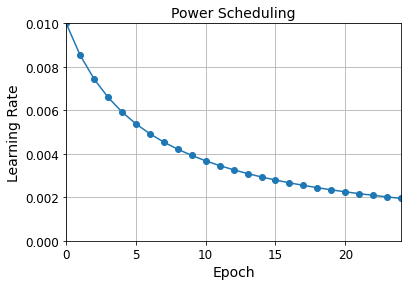

In [73]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)
plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### 지수 기반 스케줄링

```lr = lr0 * 0.1**(epoch / s)```

In [74]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [75]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [77]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
        keras.layers.Dense(10, activation="softmax")
    ]
)
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [78]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(
    X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid), callbacks=[lr_scheduler]
)

Epoch 1/25
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9192 - accuracy: 0.7429 - val_loss: 1.4256 - val_accuracy: 0.6252 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8240 - accuracy: 0.7435 - val_loss: 0.7725 - val_accuracy: 0.7698 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.7269 - accuracy: 0.7771 - val_loss: 0.7908 - val_accuracy: 0.7840 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6046 - accuracy: 0.8161 - val_loss: 0.7208 - val_accuracy: 0.8200 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.5408 - accuracy: 0.8343 - val_loss: 0.6161 - val_accuracy: 0.8424 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 11s 7ms/step - loss: 0.5221 - accuracy: 0.8444 - val_loss: 0.5747 - val_accuracy: 0.8434 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================